In [1]:
import numpy as np
import sklearn
from numpy import tanh
import sys
sys.path.append('..')
import pandas as pd
from utils import load_narma
import matplotlib.pyplot as plt
from esn import EchoStateNetwork, LeastMeanSquares

In [2]:
x_train,y_train, x_val, y_val, x_test, y_test = load_narma('../datasets/NARMA10.csv', format='np')
y_train.shape

(4000, 1)

In [8]:
input_size=1
hidden_size=300
rho_h=1.1
omega_x =1.1
washout=1000
head =LeastMeanSquares()
esn1 = EchoStateNetwork(input_size, hidden_size, rho_h, omega_x, head=head, density=1)
esn1.fit(x_train, y_train, washout=washout)


<class 'scipy.sparse._coo.coo_matrix'>


In [9]:
y_val_pred1 =esn1.predict(x_val)


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae1 = mean_absolute_error(y_val, y_val_pred1)
mse1 = mean_squared_error(y_val, y_val_pred1)



print(f'LMS head: MAE: {mae1}, MSE: {mse1}')


LMS head: MAE: 0.0009753310468586278, MSE: 1.6312109636808531e-06


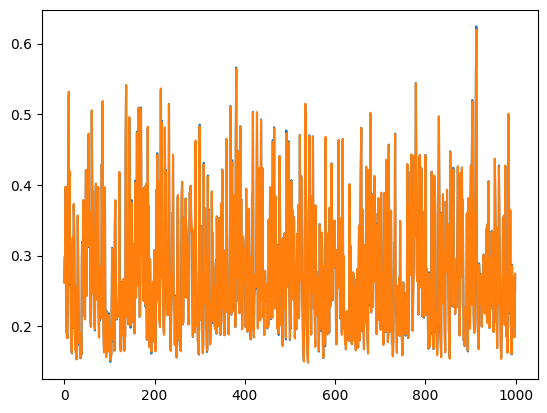

In [11]:

plt.plot(y_val)
plt.plot(y_val_pred1)


In [12]:
mg = pd.read_csv('../datasets/MG17.csv', header=None)

In [13]:
mg=np.array(mg)

In [14]:
mg.shape
mg_input =mg[:, :-10]
mg_target=mg[:, 10:]

In [15]:
mg_input.shape

(1, 9990)

In [16]:
mg_x_train = mg_input[:,:5000].T
mg_x_val = mg_input[:,5000:6000].T
mg_x_test= mg_input[:,6000:].T

mg_y_train = mg_target[:,:5000].T
mg_y_val = mg_target[:,5000:6000].T
mg_y_test= mg_target[:,6000:].T




In [17]:
esn = EchoStateNetwork(1,300, 1.1,1.1,head=LeastMeanSquares())

<class 'scipy.sparse._coo.coo_matrix'>


In [18]:
esn.fit(mg_x_train, mg_y_train)

In [19]:
mg_y_val_pred=esn.predict(mg_x_val)

In [20]:
mean_absolute_error(mg_y_val, mg_y_val_pred), mean_squared_error(mg_y_val, mg_y_val_pred)

(0.0003861850824283298, 3.098434673774332e-07)

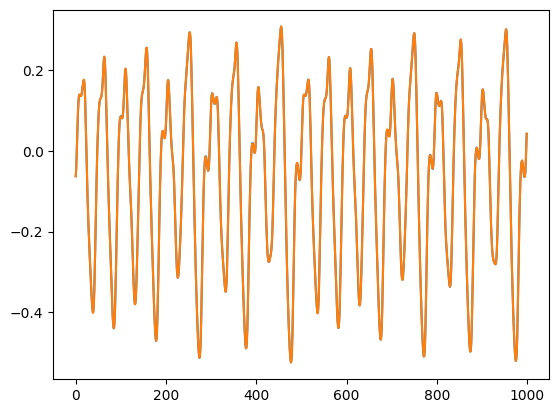

In [21]:
plt.plot(mg_y_val)
plt.plot(mg_y_val_pred)